# REINFORCE : Acrobot

![image](images/acrobot.gif)

## Description
The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

Two blue links connected by two green joints. The joint in between the two links is actuated. The goal is to swing the free end of the outer-link to reach the target height (black horizontal line above system) by applying torque on the actuator.

### Action Space
The action is discrete, deterministic, and represents the torque applied on the actuated joint between the two links.
- 0 : apply -1 torque to the actuated joint
- 1 : apply 0 torque to the actuated joint
- 2 : apply 1 torque to the actuated joint

### Observation Space
The observation is a ndarray with shape (6,) that provides information about the two rotational joint angles as well as their angular velocities.
- 0 : cosine of theta1 [-1, 1]
- 1 : sine of theta1 [-1, 1]
- 2 : cosine of theta2 [-1, 1]
- 3 : sine of theta2 [-1, 1]
- 4 : angular velocity of theta1 [-12.567 (-4 * pi), 12.567 (4 * pi)]
- 5 : angular velocity of theta2 [-28.274 (-9 * pi), 28.274 (9 * pi)]

### Reward
The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

### Starting State
Each parameter in the underlying state (theta1, theta2, and the two angular velocities) is initialized uniformly between -0.1 and 0.1. This means both links are pointing downwards with some initial stochasticity.

### Episode End
The episode ends if one of the following occurs:
- Termination: The free end reaches the target height, which is constructed as: -cos(theta1) - cos(theta2 + theta1) > 1.0
- Truncation: Episode length is greater than 500 (200 for v0)

In [5]:
import numpy as np
import gymnasium as gym
from tqdm import *
import matplotlib.pyplot as plt

In [6]:
env = gym.make("Acrobot-v1", render_mode = None)
n_actions = env.action_space.n
shape_states = env.observation_space.shape
np.random.seed(42)

## I. REINFORCE par paramétrisation

On va utiliser la fonction softmax pour paramétriser la politique. La fonction softmax prend en entrée un vecteur de paramètres $\theta$ et renvoie un vecteur de probabilité de même taille. 

The log-softmax function is defined as follows:

$$\log\left(\frac{\exp(z_i)}{\sum_j \exp(z_j)}\right)$$

where $z_i$ is the $i$-th element of a vector of logits. The gradient of the log-softmax function with respect to the logits is:

$$\frac{\partial}{\partial z_i} \log\left(\frac{\exp(z_i)}{\sum_j \exp(z_j)}\right) = \frac{\partial}{\partial z_i} \left( z_i - \log\left(\sum_j \exp(z_j)\right) \right)$$

To compute this gradient, we can start by taking the derivative of the logarithm term:

$$\frac{\partial}{\partial z_i} \log\left(\sum_j \exp(z_j)\right) = \frac{1}{\sum_j \exp(z_j)} \cdot \frac{\partial}{\partial z_i} \sum_j \exp(z_j)$$

Note that the sum in the denominator is over all the logits $z_j$, and the sum in the numerator is only over the logits that correspond to the $i$-th action. Therefore, we can simplify the expression as follows:

$$\frac{\partial}{\partial z_i} \log\left(\sum_j \exp(z_j)\right) = \frac{\exp(z_i)}{\sum_j \exp(z_j)}$$

Next, we can use the chain rule to compute the derivative of the entire log-softmax function:

$$\frac{\partial}{\partial z_i} \log\left(\frac{\exp(z_i)}{\sum_j \exp(z_j)}\right) = \frac{\partial}{\partial z_i} \left( z_i - \log\left(\sum_j \exp(z_j)\right) \right) = 1 - \frac{\exp(z_i)}{\sum_j \exp(z_j)} = 1 - \mathrm{softmax}(z)_i$$

where $\mathrm{softmax}(z)_i$ is the $i$-th element of the softmax function applied to the logits $z$. Therefore, the gradient of the log-softmax function with respect to the logits is simply the difference between 1 and the probability of selecting the $i$-th action according to the softmax function

In [15]:
def softmax(alpha) :
    proba = np.exp(alpha)
    return proba/proba.sum()

def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

def parametrization(x,theta):
	z = x.dot(theta)
	return softmax(z)

In [16]:
def REINFORCE(env, learning_rate =0.000025,gamma = 0.99, num_episodes = 10000, max_steps=500):

	n_actions = env.action_space.n
	params = np.random.rand(6,n_actions)

	print("Started REINFORCE Learning")
	for _ in trange(num_episodes):

		state = env.reset()[0][None,:]

		grads = []	
		rewards = []
		score = 0

		for _ in range(max_steps):

			probs = parametrization(state,params)
			action = np.random.choice(n_actions,p=probs[0])
			next_state,reward,done,truncated, _ = env.step(action)
			next_state = next_state[None,:] # For shape correctness

			dsoftmax = softmax_grad(probs)[action,:]
			dlog = dsoftmax / probs[0,action]
			grad = state.T.dot(dlog[None,:])

			grads.append(grad)
			rewards.append(reward)		

			score+=reward

			state = next_state

			if done or truncated:
				break

		for i in range(len(grads)):
			params += learning_rate * grads[i] * sum([ r * (gamma ** r) for t,r in enumerate(rewards[i:])])

	print("Finished REINFORCE Learning")
	return params

In [17]:
params = REINFORCE(env)

Started REINFORCE Learning


100%|██████████| 10000/10000 [03:38<00:00, 45.72it/s]

Finished REINFORCE Learning


In [18]:
params.shape

(6, 3)

## Results

In [19]:

env = gym.make("Acrobot-v1", render_mode = None)
obs, info = env.reset()

def agent_play(env, max_n_episodes=1000, max_steps=10000):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s=env.reset()[0][None,:]
        total_reward = 0
        for i in range(max_steps):
            proba = parametrization(s, params)

            action = np.random.choice([0, 1, 2], p = proba[0])
            s, r, done, tr,_ = env.step(action)
            s = s[None,:]
            total_reward+=r
            if done or tr: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    avg_num_steps = np.mean(num_steps)
    print(f'Average number of steps = {avg_num_steps}')
    return rewards, num_steps

In [20]:
rewards, num_steps = agent_play(env)

100%|██████████| 1000/1000 [00:16<00:00, 59.83it/s]

Average number of steps = 85.643


/tmp/ipykernel_307321/3679638419.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(len(rewards)), np.cumsum(rewards)/np.arange(len(rewards)), label="Cumulative Average Reward for Reinforce algorithms")


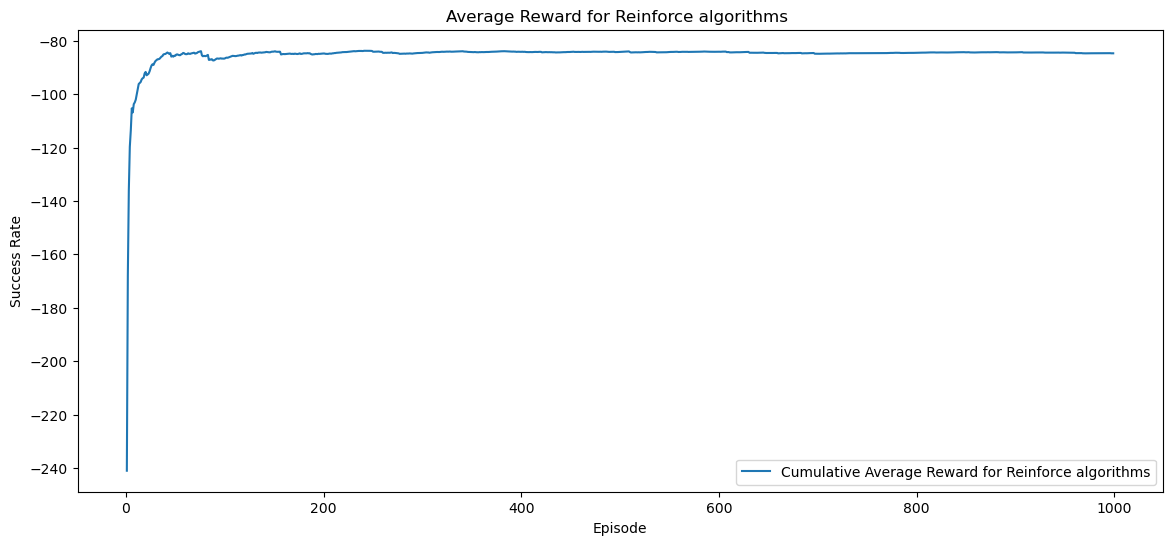

In [22]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards)), np.cumsum(rewards)/np.arange(len(rewards)), label="Cumulative Average Reward for Reinforce algorithms")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Reward for Reinforce algorithms ')
plt.legend()
plt.show()